<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/Solar_Panel_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd

In [5]:
from google.colab import files
uploaded = files.upload()

Saving 80929.csv to 80929 (1).csv


In [6]:
data_path = '/content/80929.csv'
df = pd.read_csv(data_path, delimiter=',')  #here we're reading our csv file into a Pandas DataFrame
df

,Date,Power (kW)
0,9/30/2014 8:50,0.0
1,9/30/2014 8:55,1032.0
2,9/30/2014 9:00,1082.5
3,9/30/2014 9:05,1094.5
4,9/30/2014 9:10,1175.5
...,...,...
302423,6/4/2020 19:48,1.5
302424,6/4/2020 19:53,0.0
302425,6/4/2020 19:56,0.0
302426,6/4/2020 20:01,0.0


In [11]:
df_y = df.drop(columns=['Date'])
df_y

,Power (kW)
0,0.0
1,1032.0
2,1082.5
3,1094.5
4,1175.5
...,...
302423,1.5
302424,0.0
302425,0.0
302426,0.0


In [16]:
#Now we convert the data into a numpy array - many of the algorithms we're 
#interested in will only take numpy arrays, not dataframes
y = df_y.to_numpy()

#Create an input vector of just the values between 0 and 302,427
X = np.linspace(0, y.shape[0], y.shape[0])


(0.0, 600.0)

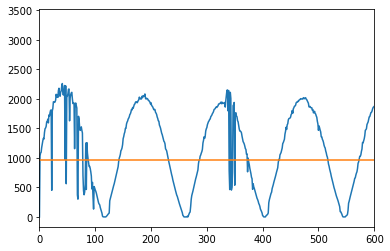

In [22]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True) #The fit_intercept=True means that 
                                             #we are not assuming the data is 
                                             #pre-centered
model.fit(X[:, np.newaxis], y) #The np.newaxis is required here because when x 
                               #was created, it was 1d: shape = (50,). Model.fit 
                               #requires 2d data. New shape = (50,1)

y_hat = model.predict(X[:, np.newaxis])

plt.plot(X, y)
plt.plot(X, y_hat);
plt.xlim(0, 600)